# Analyze data

In [1]:
%matplotlib notebook
%pylab
# %matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import os
# os.environ['OPENCL_VENDOR_PATH'] = '/etc/OpenCL/vendors'

#sys.path.append(os.path.expanduser('/asap3/petra3/gpfs/p10/2018/data/11004977/processed/jupyter (copy 1)/Xana'))
from Xana import Xana
from Xana import CorrFunc
from Xana import Soq


import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pandas import read_csv
import pickle as pkl
from scipy.constants import Boltzmann,pi,e
from matplotlib import gridspec
import matplotlib.ticker as ticker

from scipy.special import gamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import h5py

#read meta data files
import configparser as configparser
import ast

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


blosc filter already loaded, skip it.
bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.
zstd filter already loaded, skip it.
fcidecomp filter already loaded, skip it.


In [2]:
def GetSetup(setupfile = './setupfiles/example_setup.pkl'): 
    """extracts information from the setup file

    Parameters
    ----------
    setupfile : str
        The file location of the setup file
    

    Returns
    -------
    list
        a list with 
            qValues: q values in inverse nanometer
            maskFile: path to mask file
            qRoi: array with cooridates for pixels in each ROI
            beamCenter: beam center in pixels
    """
    setupFile = open(setupfile,'rb')
    setupParams = pkl.load(setupFile)
    setupFile.close()
    
    qValues = setupParams.qv #all properties are listed under https://github.com/reiserm/Xana/blob/master/Xana/Setup.py
    maskFile = setupParams.maskfile
    beamCenter = setupParams.center
    qRoi = setupParams.qroi
    
    return([qValues,maskFile,qRoi,beamCenter])

def calculate_cut_length(ttc, ctime,t_delay,nframes, cut='diagonal', t_range=None, t_cutoff=None):
    '''
    calculate the length of a diagonal/horizontal cut throuth a TTC at a given starting positions

    Parameters
    ----------
    ttc : 2d array
        two time correlation function
    ctime: double
        cut time in seconds where the cut should start on the diagonal of the TTC
    t_delay: double
        delay time of measurement in seconds (exposure time + shutter time)
    nframes: int
        number of frames for TTC
    cut: 'diagonal'/'horizontal'
        direction of TTC cut
    t_range: double
        obtain g2 cut from average over this range. More averaging -> better SNR but less time resolution
    t_cutoff: double
        decrease length by t_cutoff

    Returns
    -------
    int
        number of ttc pixels/frames for cut
    '''
    index_start = 0
    index_period = 0
    t_period = 0
    index_end = ttc.shape[0]
    tm = t_delay * nframes


    if t_cutoff is None:
        t_cutoff = 0
        ind_cutoff = 0
    else:
        ind_cutoff = int(round(t_cutoff /t_delay))
    if t_range is None:
        t_range = 10 * t_delay

    index_range = range(int(np.round(t_range / t_delay)))

    index_start = round(ctime / t_delay)
    index_period = int(index_end - index_start-index_range[-1])
    t_period = index_period * t_delay
        
    if cut == 'diagonal':

        start_smaller_time = index_start
        start_higher_time = index_start+len(index_range)
            
        # calculate maximum number of timesteps
        if start_smaller_time < nframes/2:
            number_smaller_time = 2*start_smaller_time
        else:
            if nframes %2 == 0:  #even number of frames
                number_smaller_time = 2*(nframes - start_smaller_time)
            else:  #odd number of frames
                number_smaller_time = 2*(nframes-1 - start_smaller_time)


        if start_higher_time < nframes/2:
            number_higher_time = 2*start_higher_time
        else:
            if nframes %2 == 0:  #even number of frames
                number_higher_time = 2*(nframes - start_higher_time)
            else:  #odd number of frames
                number_higher_time = 2*(nframes-1 - start_higher_time)

        num_time_steps = int(min([number_higher_time,number_smaller_time])-ind_cutoff)
    return num_time_steps

    

def cut_ttc(ttc, times,t_delay,nframes, cut='diagonal', t_range=None, t_cutoff=None, reduce=True, nbins=None, plot=False):
    '''Function to perform TTC cutting to obtain one time correlation function

    Parameters
    ----------
    ttc : 2d array
        two time correlation function
    times: array
        start times in seconds for cuts
    t_delay: double
        delay time of measurement in seconds (exposure time + shutter time)
    nframes: int
        number of frames for TTC
    cut: 'diagonal'/'horizontal'
        direction of TTC cut
    t_range: double
        obtain g2 cut from average over this range. More averaging -> better SNR but less time resolution
    t_cutoff: double
        decrease length by t_cutoff
    reduce: bool
        select if logarithmic binnig should be done
    bins: int
        number of bins for logarithmic averaging. Default is 60
    plot: bool
        option for displaying cuts


    Returns
    -------
    tau: dict
        dict with time axis for every cut
    g2: dict
        dict with g2 values for every cut
    '''
    index_start = np.zeros(len(times))
    index_period = np.zeros(len(times))
    t_period = np.zeros(len(times))
    index_end = ttc.shape[0]
    tm = t_delay * nframes


    if t_cutoff is None:
        t_cutoff = 0
        ind_cutoff = 0
    else:
        ind_cutoff = int(round(t_cutoff /t_delay))
    if t_range is None:
        t_range = 10 * t_delay

    index_range = range(int(np.round(t_range / t_delay)))

    for ind_time, time in enumerate(times):

        index_start[ind_time] = round(time / t_delay)
        index_period[ind_time] = int(index_end - index_start[ind_time]-index_range[-1])
        t_period[ind_time] = index_period[ind_time] * t_delay

    tau, g2, g2_sum = dict(), dict(), dict()

    if cut == 'horizontal':

        # loop over all waiting times
        for ind_time, time in enumerate(times):
            tau[ind_time] = t_delay * np.array(range(1, int(index_period[ind_time]) + 1))
            g2[ind_time], g2_sum[ind_time] = np.zeros(
                int(index_period[ind_time])), np.zeros(int(index_period[ind_time]))
            # loop over t1-axis
            
            for x in index_range: # loop over TTC lines that are averaged for this time cut
                ttc_pos = int(index_start[ind_time]+x)
                g2_sum[ind_time] += ttc[ttc_pos,
                                           ttc_pos:int(ttc_pos+index_period[ind_time])]
            g2[ind_time] = g2_sum[ind_time] /len(index_range)
            
    elif cut == 'diagonal':

        for ind_time, time in enumerate(times):
            start_smaller_time = index_start[ind_time]
            start_higher_time = index_start[ind_time]+len(index_range)
            
            # calculate maximum number of timesteps
            if start_smaller_time < nframes/2:
                number_smaller_time = 2*start_smaller_time
            else:
                if nframes %2 == 0:  #even number of frames
                    number_smaller_time = 2*(nframes - start_smaller_time)
                else:  #odd number of frames
                    number_smaller_time = 2*(nframes-1 - start_smaller_time)
            
            
            if start_higher_time < nframes/2:
                number_higher_time = 2*start_higher_time
            else:
                if nframes %2 == 0:  #even number of frames
                    number_higher_time = 2*(nframes - start_higher_time)
                else:  #odd number of frames
                    number_higher_time = 2*(nframes-1 - start_higher_time)
                       
            num_time_steps = int(min([number_higher_time,number_smaller_time])-ind_cutoff)
            
            tau[ind_time] = (np.arange(num_time_steps) + 1) * t_delay
            g2_sum[ind_time] = np.zeros(num_time_steps)
            g2[ind_time] = np.zeros(num_time_steps)
            
            current_ttc_index_x,current_ttc_index_y = index_start[ind_time],index_start[ind_time]

            for t_ind in range(num_time_steps):
                for r_ind in index_range:
                    g2_sum[ind_time][t_ind] += ttc[int(current_ttc_index_x+r_ind),int(current_ttc_index_y+r_ind)]
                if t_ind%2==0:#step to the right
                    current_ttc_index_x +=1
                else: #step down
                    current_ttc_index_y -=1
                
            g2[ind_time] = g2_sum[ind_time] / (len(index_range))


    if reduce:
        if nbins is None:
            nbins = 60
        for q_ind in [0]:
            for ind_time, time in enumerate(times):

                log_inds = np.insert(np.unique(np.logspace(np.log10(1), np.log10(
                    len(tau[ind_time]) - 1), nbins, dtype=int)), 0, 0)
                new_g2 = np.zeros(np.shape(log_inds))

                for ind, log_ind in enumerate(log_inds):
                    if ind == 0:
                        new_g2[ind] = g2[ind_time][0]
                    elif log_inds[ind] - log_inds[ind - 1] == 1:
                        if log_inds[ind] == ind:
                            new_g2[ind] = g2[ind_time][ind]
                        else:
                            new_g2[ind] = g2[ind_time][log_inds[ind - 1]
                                :log_inds[ind]]
                    elif log_inds[ind] - log_inds[ind - 1] > 1:
                        new_g2[ind] = np.mean(
                            g2[ind_time][log_inds[ind - 1]:log_inds[ind]])

                g2[ind_time] = new_g2
                tau[ind_time] = tau[ind_time][log_inds]
                
    if plot:
        fig, ax = plt.subplots()
        for ind_time, time in enumerate(times):
            line = ax.semilogx(tau[ind_time], g2[ind_time], marker='o', c=plt.cm.jet(
                (ind_time + 1) / len(times)), ls='None', ms=6, label=str(round(time,1)))
        add_colorbar(ax,times,label=r'$t_{\mathrm{w}}$(s)')

        ax.set_xlabel(r'$\tau$ / s', fontsize=18)
        ax.set_ylabel(r'$g_2$', fontsize=18)
        fig.tight_layout()
    

    return tau, g2

def fit_g2(times, tau ,g2, fit_model=2, plot_fit=False,max_fit_points = None, **fitkwargs):
    '''Function to fit one time correlation function with single or double exponential KWW fit

    Parameters
    ----------
    times : array
        times in seconds where the ttc has been cut
    tau: dict
        time axis for g2
    g2: dict
        g2s obtained from cuts
    fit_model: int
        1: single exponential fit, 2: double exponential fit
    plot_fit: bool
        create figure with fit results
    max_fit_points: int
        number of points of g2 that are included.


    Returns
    -------
    popt: 2d array
        array with shape (number of cuts x number of fit parameters) that contains results for parameter after fitting
    perr: 2d array
        array with shape (number of cuts x number of fit parameters) that contains square root of entries on diagonal of covariance matric e.g. standard deviation
    g2_calc: dict
        g2 fit result for every cut
    fig: figure
        figure with plot results
    '''

    if fit_model == 1:

        # self.popt, self.perr, pcov = dict(), dict(), dict()
        popt = np.zeros((len(times), 4))
        perr = np.zeros((len(times), 4))
        pcov = np.zeros((len(times), 4,4))



        def g2_model(t, beta, Gamma, kww, off):
            g2 = np.add(1 + off , beta * np.exp(-2 * (Gamma * t) ** kww))
            return g2
        par_names = [r'$\beta$',r'$\Gamma(s^{-1})$',r'KWW',r'offset']

    if fit_model == 2:
        popt = np.zeros((len(times), 7))
        perr = np.zeros((len(times), 7))
        pcov = np.zeros((len(times), 7, 7))

        def g2_model(t, beta, beta_0, Gamma1, kww1, Gamma2, kww2,off):
            g2 = 1 + off+ beta * \
                (beta_0 * np.exp(-2 * (Gamma1 * t) ** (kww1)) + (1-beta_0) * \
                np.exp(-2 * (Gamma2 * t) ** (kww2)))
            return g2
        par_names = [r'$\beta$',r'$\Gamma_1(s^{-1})$',r'KWW_1',r'$\beta_0$',r'$\Gamma_2(s^{-1})$',r'KWW_2',r'offset']


    if 'p0' in fitkwargs:
        p0 = fitkwargs['p0']
    else:
        p0 = None

    if 'bounds' in fitkwargs:
        bounds = fitkwargs['bounds']
    else:
        bounds = (None, None)

    if 'maxfev' in fitkwargs:
        maxfev = fitkwargs['maxfev']
    else:
        maxfev = 10000

    if 'fit_range' in fitkwargs:
        fit_range = fitkwargs['fit_range']
    else:
        fit_range = None



    g2_calc = dict()
    for ind_time, time in enumerate(times):
        if max_fit_points is None:
            popt[ind_time][:], pcov[ind_time][:,:] = curve_fit(g2_model, tau[ind_time], g2[ind_time], p0=p0, bounds=bounds)
        else:
            popt[ind_time][:], pcov[ind_time][:,:] = curve_fit(g2_model, tau[ind_time][:max_fit_points], g2[ind_time][:max_fit_points], p0=p0, bounds=bounds)

        perr[ind_time][:] = np.sqrt(np.diag(pcov[ind_time][:,:]))
        g2_calc[ind_time] = g2_model(tau[ind_time], *popt[ind_time][:])

    if plot_fit:
        if fit_model ==1:
            X = [(2,4,3), (2,4,4), (2,4,7),(2,4,8) ]
            fig = plt.figure(figsize=(10,5))
            ax_par = []
            ax_0=fig.add_subplot(1, 2, 1)

            for nrows, ncols, plot_number in X:
                ax_par.append(fig.add_subplot(nrows, ncols, plot_number))

            for ind_time, time in enumerate(times):
                line = ax_0.semilogx(tau[ind_time], g2[ind_time], marker='o', c=plt.cm.jet(
                    (ind_time + 1) / len(times)), ls='None', ms=5, label=str(np.round(time,1)),alpha=0.7)

                line2 = ax_0.semilogx(tau[ind_time], g2_model(tau[ind_time],*popt[ind_time][:]), c=plt.cm.jet((ind_time + 1) / len(times)), ls='-', ) 
                if max_fit_points is not None:
                    line3 = ax_0.axvline(tau[0][max_fit_points],ymin=0,ymax=1)
            colors=color=plt.cm.jet(np.linspace(0,1,len(times)))
            for p in range(len(popt[0])):
                if fit_model==1:
                    ax_par[p].set_ylabel(par_names[p])
                    ax_par[p].set_xlabel(r'$t_{\mathrm{w}}$(s)')
                for ind_time, time in enumerate(times):
                    ax_par[p].errorbar(x=time,y=popt[ind_time][p],yerr=perr[ind_time][p],color=colors[ind_time],marker='o')

        if fit_model == 2:
            fig = plt.figure(figsize=(10,5))
            ax_0=fig.add_subplot(1, 2, 1)
            X = [(2,4,3), (2,4,4), (2,4,7),(2,4,8) ]

            ax_par = []
            for nrows, ncols, plot_number in X:
                ax_par.append(fig.add_subplot(nrows, ncols, plot_number))

            for ind_time, time in enumerate(times):
                line = ax_0.semilogx(tau[ind_time], g2[ind_time], marker='o', c=plt.cm.jet(
                    (ind_time + 1) / len(times)), ls='None', ms=6, label=str(np.round(time,1)))

                line2 = ax_0.semilogx(tau[ind_time], g2_model(tau[ind_time],*popt[ind_time][:]), c=plt.cm.jet((ind_time + 1) / len(times)), ls='-', ) 
                if max_fit_points is not None:
                    line3 = ax_0.axvline(tau[0][max_fit_points],ymin=0,ymax=1)
            colors=plt.cm.jet(np.linspace(0,1,len(times)))
            par_names_leg = [r'$\beta$',r'$\Gamma(s^{-1})$',r'KWW',r'$\beta_0$']
            par_ax = [ax_par[0],ax_par[3],ax_par[1],ax_par[2],ax_par[1],ax_par[2],ax_par[0]]
            markerstyle = ['o','o','o','o','^','^','o']
            for p1 in range(4):
                ax_par[p1].set_ylabel(par_names_leg[p1])
                ax_par[p1].set_xlabel(r'$t_{\mathrm{w}}$(s)')

            for p in range(len(popt[0])-1):
                for ind_time, time in enumerate(times):
                    par_ax[p].errorbar(x=time,y=popt[ind_time][p],yerr=perr[ind_time][p],color=colors[ind_time],marker=markerstyle[p])
        ax_0.set_ylabel(r'$g^{(2)}( \tau)$')
        ax_0.set_xlabel(r'$\tau(s)$')
        add_colorbar(ax_0,times,label=r'$t_{\mathrm{w}}$(s)')

    return popt, perr, g2_calc, fig
    
def fit_g2_arrays(q_labels, tau ,g2, fit_model=2, plot_fit=False,max_fit_points = None, **fitkwargs):
    """Function to fit one time correlation functions from different q values with single or double exponential KWW fit

    Parameters
    ----------
    q_labels : array
        q labels for different gws
    tau: array
        time axis for g2, same for every g2 in this case
    g2: 2d array
        g2s obtained from single cut at different qs
    fit_model: int
        1: single exponential fit, 2: double exponential fit
    plot_fit: bool
        create figure with fit results
    max_fit_points: int
        number of points of g2 that are included.


    Returns
    -------
    popt: 2d array
        array with shape (number of cuts x number of fit parameters) that contains results for parameter after fitting
    perr: 2d array
        array with shape (number of cuts x number of fit parameters) that contains square root of entries on diagonal of covariance matric e.g. standard deviation
    g2_calc: dict
        g2 fit result for every cut
    fig: figure
        figure with plot results
    
    """
    if fit_model == 1:

        # self.popt, self.perr, pcov = dict(), dict(), dict()
        popt = np.zeros((len(q_labels), 4))
        perr = np.zeros((len(q_labels), 4))
        pcov = np.zeros((len(q_labels), 4,4))



        def g2_model(t, beta, Gamma, kww, off):
            g2 = np.add(1 + off , beta * np.exp(-2 * (Gamma * t) ** kww))
            return g2
        par_names = [r'$\beta$',r'$\Gamma(s^{-1})$',r'KWW',r'offset']

    if fit_model == 2:
        popt = np.zeros((len(q_labels), 7))
        perr = np.zeros((len(q_labels), 7))
        pcov = np.zeros((len(q_labels), 7, 7))

        def g2_model(t, beta, beta_0, Gamma1, kww1, Gamma2, kww2,off):
            g2 = 1 + off+ beta * \
                (beta_0 * np.exp(-2 * (Gamma1 * t) ** (kww1)) + (1-beta_0) * \
                np.exp(-2 * (Gamma2 * t) ** (kww2)))
            return g2
        par_names = [r'$\beta$',r'$\Gamma_1(s^{-1})$',r'KWW_1',r'$\beta_0$',r'$\Gamma_2(s^{-1})$',r'KWW_2',r'offset']

    if 'p0' in fitkwargs:
        p0 = fitkwargs['p0']
    else:
        p0 = None

    if 'bounds' in fitkwargs:
        bounds = fitkwargs['bounds']
    else:
        bounds = (None, None)

    if 'maxfev' in fitkwargs:
        maxfev = fitkwargs['maxfev']
    else:
        maxfev = 10000

    if 'fit_range' in fitkwargs:
        fit_range = fitkwargs['fit_range']
    else:
        fit_range = None



    g2_calc = dict()
    for iq, q_val in enumerate(q_labels):
        # self.g2_calc[ind_q][ind_time] = np.zeros(self.tau[ind_q][ind_time].shape[0])
        if max_fit_points is None:
            popt[iq][:], pcov[iq][:,:] = curve_fit(g2_model, tau, g2[iq], p0=p0, bounds=bounds)
        else:
            popt[iq][:], pcov[iq][:,:] = curve_fit(g2_model, tau[:max_fit_points], g2[iq][:max_fit_points], p0=p0, bounds=bounds)

        perr[iq][:] = np.sqrt(np.diag(pcov[iq][:,:]))
        g2_calc[iq] = g2_model(tau, *popt[iq][:])

    if plot_fit:
        if fit_model ==1:
            X = [(2,4,3), (2,4,4), (2,4,7),(2,4,8) ]
            fig = plt.figure(figsize=(10,5))
            ax_par = []
            ax_0=fig.add_subplot(1, 2, 1)
            colors=color=plt.cm.RdYlGn(np.linspace(0,1,len(q_labels)))

            for nrows, ncols, plot_number in X:
                ax_par.append(fig.add_subplot(nrows, ncols, plot_number))

            for iq, q_val in enumerate(q_labels):
                line = ax_0.semilogx(tau, g2[iq], marker='o', c=colors[iq], 
                                     ls='None', ms=5, label=str(np.round(q_val,4)),alpha=0.7)

                    #print(popt[ind_time])
                line2 = ax_0.semilogx(tau, g2_model(tau,*popt[iq][:]), c=colors[iq], ls='-', ) 
                if max_fit_points is not None:
                    line3 = ax_0.axvline(tau[max_fit_points],ymin=0,ymax=1)

            for p in range(len(popt[0])):
                if fit_model==1:
                    ax_par[p].set_ylabel(par_names[p])
                    ax_par[p].set_xlabel(r'q(nm$^{-1}$)')
                for iq, q_val in enumerate(q_labels):
                    #print('time: {:.0f} parameter {:.3f}'.format(time,popt[ind_time][p]))
                    ax_par[p].errorbar(x=q_val,y=popt[iq][p],yerr=perr[iq][p],color=colors[iq],marker='o')
        if fit_model == 2:
            fig = plt.figure(figsize=(10,5))
            ax_0=fig.add_subplot(1, 2, 1)
            X = [(2,4,3), (2,4,4), (2,4,7),(2,4,8) ]
            colors=plt.cm.RdYlGn(np.linspace(0,1,len(q_labels)))
            ax_par = []
            for nrows, ncols, plot_number in X:
                ax_par.append(fig.add_subplot(nrows, ncols, plot_number))

            for iq, q_val in enumerate(q_labels):
                line = ax_0.semilogx(tau, g2[iq], marker='o', c=colors[iq], 
                                     ls='None', ms=5, label=str(np.round(q_val,4)),alpha=0.7)

                    #print(popt[ind_time])
                line2 = ax_0.semilogx(tau, g2_model(tau,*popt[iq][:]), c=colors[iq], ls='-', ) 
                if max_fit_points is not None:
                    line3 = ax_0.axvline(tau[max_fit_points],ymin=0,ymax=1)

            par_names_leg = [r'$\beta$',r'$\Gamma(s^{-1})$',r'KWW',r'$\beta_0$']
            par_ax = [ax_par[0],ax_par[3],ax_par[1],ax_par[2],ax_par[1],ax_par[2],ax_par[0]]
            markerstyle = ['o','o','o','o','^','^','o']
            for p1 in range(4):
                ax_par[p1].set_ylabel(par_names_leg[p1])
                ax_par[p1].set_xlabel(r'q(nm$^{-1}$)')

            for p in range(len(popt[0])-1):
                for iq, q_val in enumerate(q_labels):
                    #print('time: {:.0f} parameter {:.3f}'.format(time,popt[ind_time][p]))
                    par_ax[p].errorbar(x=q_val,y=popt[iq][p],yerr=perr[iq][p],color=colors[iq],marker=markerstyle[p])

        ax_0.set_ylabel(r'$g^{(2)}( \tau)$')
        ax_0.set_xlabel(r'$\tau(s)$')
        leg = ax_0.legend(fontsize=12, ncol=2,
                        title=r'q(nm$^{-1}$)')


    return popt, perr, g2_calc, fig

def Dosis(t, ab):
    '''Function to calculate dosis for water equivalent accumulated over time t with absorber ab

    Typical setup for an USAXS experiment at the P10 coherence applications beam line at DESY is used
    

    Parameters
    ----------
    t: double
        exposure time in seconds
    ab: int
        number of 25 micron silicon absorbers inserted before the sample


    Returns
    -------
    double
        dosis in kilo gray
    
    '''
    Phi_c = 6e10*(0.729**ab) # reduced flux in photons per second
    E_c =8540*e  #J/ph photon energy
    d_s =0.0015 #m sample thickness
    A = 0.72# absorption in 1mm of water
    Phi = 1 # volume fraction
    z_sq = 100e-06*100e-06 #m^2 beam area

    rho = 1000 #kg/m^3 sample mass density
    return(np.multiply(t,Phi_c*E_c*A*Phi/(z_sq*d_s*rho))/1000) #return Dose in kGy

#relative transmission of each absorber configuration
transmission_dict = {'0':1,'1':0.73,'2':0.53,'4':0.28,'6':0.15,'8':0.08,'12':0.023,'16':0.0068,'18':0.0036,'24':0.0006,'32':0.00005}

def folder_structure(name, node):
    ''' function for displaying content of h5 files'''
    if isinstance(node, h5py.Group):
        print(node.name)
    elif isinstance(node, h5py.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'contains numeric data')
        else:
            print('\t', node.name, node.shape)
            

def add_colorbar(ax, vec, label=None):
    ''' function for adding colorbar to an existing axes

    Parameters
    ----------
    ax: axis
        existing axis 
    vec: list/array
        the color bar spans the range min(vec) to max(vec)
    label: string
        label for colorbar


    '''
    vec = np.array(vec)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=vec.min(), vmax=vec.max())

    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(label)

## select measurement, create hdf5 file, fill meta data

In [3]:
dataSets = pd.read_csv('measurement_set.csv', delimiter=';',header=0,)

In [4]:
print(dataSets)

    meas_id                 measurement
0         0        m019_eggwhite_50C_bd
1         1        m020_eggwhite_53C_bd
2         2        m021_eggwhite_57C_bd
3         3        m023_eggwhite_60C_bd
4         4        m025_eggwhite_63C_bd
5         5        m026_eggwhite_65C_bd
6         6        m028_eggwhite_68C_bd
7         7        m029_eggwhite_70C_bd
8         8        m051_eggwhite_73C_bd
9         9        m060_eggwhite_75C_bd
10       10        m050_eggwhite_78C_bd
11       11        m046_eggwhite_80C_bd
12       12        m059_eggwhite_85C_bd
13       13   m022_eggwhite_57C_cycling
14       14   m024_eggwhite_60C_cycling
15       15   m027_eggwhite_65C_cycling
16       16  m049_eggwhite_65C_standing
17       17  m030_eggwhite_70C_standing
18       18   m031_eggwhite_70C_cycling
19       19   m061_eggwhite_75C_cycling
20       20  m062_eggwhite_75C_standing
21       21   m057_eggwhite_80C_cycling
22       22  m058_eggwhite 80C_standing


In [5]:
measurement_no = 7
meas_code = dataSets['measurement'][measurement_no].partition("_")[0] # extract measurement number

if not os.path.exists(f'Figures/{meas_code}'): # create folder for figures
    os.makedirs(f'Figures/{meas_code}')
    
setupfile = 'setupfiles/USAXS_e4m_12q.pkl'
d2 = Xana()
d2.loadsetup(setupfile)
d2.load_db('./'+str(dataSets['measurement'][measurement_no])+'/analysis_database.pkl') # load Xana data base

q_values,maskfile,_,beam_center = GetSetup(setupfile)

d2.db

Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/setupfiles/USAXS_e4m_12q.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/m029_eggwhite_70C_bd/analysis_database.pkl
Successfully loaded database


,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir
0,True,m029_eggwhite_70C_bd,xpcs,2022-08-28 21:20:43.927305,s0001_0000.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,1.0,0.0,0.50001,0.500,0.00001,2000.0,0.0,1999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
1,True,m029_eggwhite_70C_bd,xpcs,2022-08-28 21:21:28.993496,s0002_0001.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,2.0,0.0,0.20001,0.200,0.00001,1000.0,0.0,999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
2,True,m029_eggwhite_70C_bd,xpcs,2022-08-28 21:22:13.280305,s0003_0002.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,3.0,0.0,0.20001,0.200,0.00001,1000.0,0.0,999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
3,True,m029_eggwhite_70C_bd,xpcs,2022-08-28 21:23:45.508107,s0004_0003.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,4.0,0.0,0.10001,0.100,0.00001,2000.0,0.0,1999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
4,True,m029_eggwhite_70C_bd,xpcs,2022-08-28 21:27:07.305351,s0005_0004.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,5.0,0.0,0.00501,0.005,0.00001,4000.0,0.0,3999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,True,m029_eggwhite_70C_bd,xpcs,2023-03-13 16:01:11.166967,s0012_0611.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,12.0,0.0,0.04001,0.040,0.00001,5000.0,0.0,4999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
612,True,m029_eggwhite_70C_bd,xpcs,2023-03-13 16:06:08.277545,s0013_0612.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,13.0,0.0,0.00501,0.005,0.00001,4000.0,0.0,3999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
613,True,m029_eggwhite_70C_bd,xpcs,2023-03-13 16:14:01.601591,s0014_0613.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,14.0,0.0,0.04001,0.040,0.00001,5000.0,0.0,4999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...
614,True,m029_eggwhite_70C_bd,xpcs,2023-03-13 16:18:54.784741,s0015_0614.pkl,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,/asap3/petra3/gpfs/p10/2022/data/11015476/proc...,,15.0,0.0,0.00501,0.005,0.00001,4000.0,0.0,3999.0,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...


In [6]:
logbook = pd.read_csv('egg_logbook.csv', delimiter=';',header=0,)

In [7]:
sublog = logbook.loc[logbook.meas_id == measurement_no]
print(sublog)

     meas_id           measurement  temp  ser  ab
101        7  m029_eggwhite_70C_bd    70    1  24
102        7  m029_eggwhite_70C_bd    70    2  18
103        7  m029_eggwhite_70C_bd    70    3  16
104        7  m029_eggwhite_70C_bd    70    4  12
105        7  m029_eggwhite_70C_bd    70    5   8
106        7  m029_eggwhite_70C_bd    70    6   8
107        7  m029_eggwhite_70C_bd    70    7   6
108        7  m029_eggwhite_70C_bd    70    8   6
109        7  m029_eggwhite_70C_bd    70    9   4
110        7  m029_eggwhite_70C_bd    70   10   4
111        7  m029_eggwhite_70C_bd    70   11   2
112        7  m029_eggwhite_70C_bd    70   12   2
113        7  m029_eggwhite_70C_bd    70   13   1
114        7  m029_eggwhite_70C_bd    70   14   1
115        7  m029_eggwhite_70C_bd    70   15   0
116        7  m029_eggwhite_70C_bd    70   16   0


## Add metadata

In [8]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','a') as f:
    f.attrs['facility'] = 'Petra III'
    f.attrs['beamline'] = 'P10'
    f.attrs['detector'] = 'Eiger4M'
    f.attrs['experiment_ID'] = 11015476
    f.attrs['photon_energy_keV'] = 8.54
    f.attrs['beamsize_micron'] = (100,100)
    f.attrs['distance_m'] = 21.2
    f.attrs['flux_phs'] = 6e10
    group = f.create_group('scan_info')
    group.create_dataset('mask_file', data=np.load(maskfile))
    group.attrs['beam_center_y']= 1200
    group.attrs['beam_center_z']= 1270
    group.attrs['cooking_temperature']= '70C'
    group.attrs['cooking_duration_s']= 2460
    group.attrs['salt_concentration']= '0mM'
    group.attrs['cooking_environment']= 'water bath'
    
    f.visititems(folder_structure)
    
    f.flush()

/scan_info
	 /scan_info/mask_file (2167, 2070)


## Loop over series

In [9]:
sublog_id = 8 # choose series from measurement

# display logbook entries for measurement
print('measurement: ' + sublog.iloc[sublog_id]['measurement'])
print('series: ' + str(sublog.iloc[sublog_id]['ser']))
print('absorber: ' + str(sublog.iloc[sublog_id]['ab']))

absorber = sublog.iloc[sublog_id]['ab']
series = sublog.iloc[sublog_id]['ser']

with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if 'scan_{:.0f}'.format(series) not in f:
        group = f.create_group('scan_{:.0f}'.format(series))
        group.attrs['absorber']= absorber
        group.attrs['transmission']= transmission_dict[str(absorber)]

measurement: m029_eggwhite_70C_bd
series: 9
absorber: 4


# Part I: XPCS TTC analysis

In [10]:
ind_xpcs = d2.db[(d2.db['series']==series) & (d2.db['analysis']=='xpcs')].index.values # get XPCS entry in data base
t_exp = d2.db['t_exposure'][ind_xpcs[0]] # get exposure time in s
print(ind_xpcs)
print(t_exp)

[  8 608]
0.005


## Loop over q values

In [11]:
q_ind = 0 # choose q ROI defined in setup

with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f: # create structure in hdf5 file
    if '/scan_{:.0f}/q_{:.0f}'.format(series,q_ind) not in f:
        f['/scan_{:.0f}'.format(series)].create_group('q_{:.0f}'.format(q_ind))
        f['/scan_{:.0f}/q_{:.0f}'.format(series,q_ind)].attrs['q_nm']= q_values[q_ind]

### TTC extraction

<IPython.core.display.Javascript object>


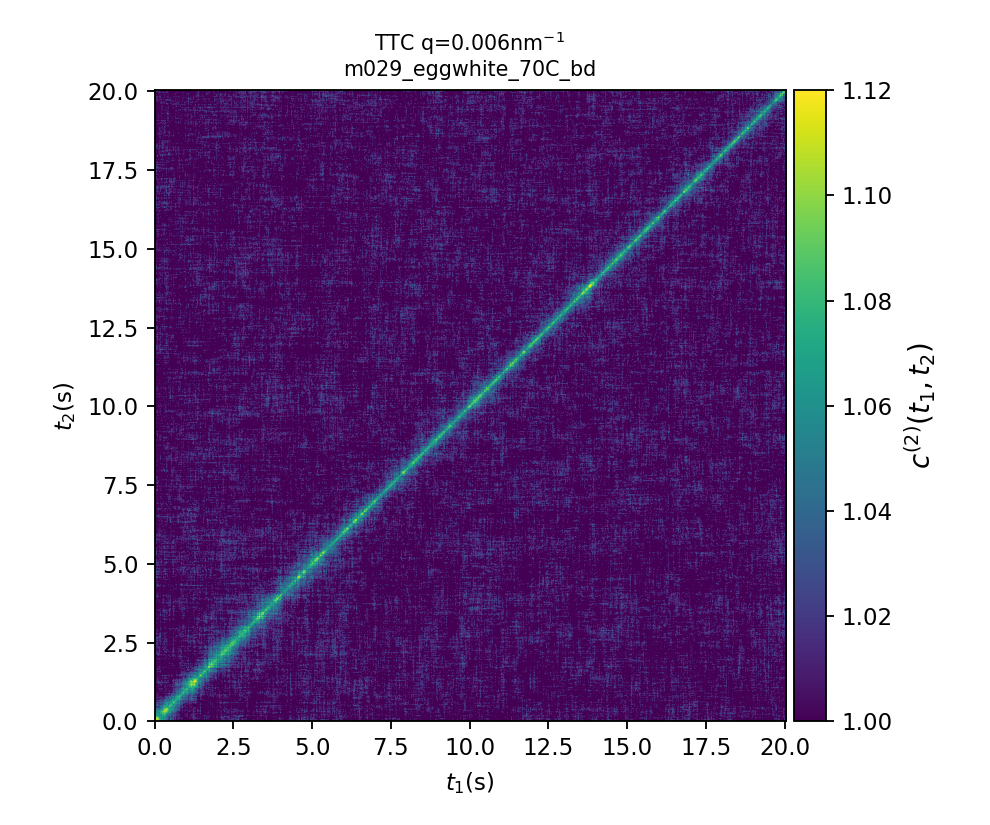

In [12]:
tt = d2.get_item(ind_xpcs[0])['twotime_xy'] # get time labels of TTC
ttc = d2.get_item(ind_xpcs[0])['twotime_corf'][q_ind][:,:] # get c2 values of TTC

# plot ttc
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(ttc,origin='lower',extent=([tt[0],tt[-1],tt[0],tt[-1]]),vmin=1,vmax=1.12)
ax.set_xlabel('$t_1$(s)')
ax.set_ylabel('$t_2$(s)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('TTC q={:.03}'.format(q_values[q_ind]) +'$\mathrm{nm^{-1}}$ \n' +str(dataSets['measurement'][measurement_no]),fontsize=9)
cax.set_ylabel('$c^{(2)}(t_1,t_2)$',fontsize=12)
plt.tight_layout()

# save figure
plt.savefig(f'Figures/{meas_code}/scan{series}_q{q_ind}_TTC.png',format='png',transparent=True)

In [13]:
# save TTC to data tree
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/q_{:.0f}/ttc'.format(series,q_ind) not in f:
        grp = f['/scan_{:.0f}/q_{:.0f}'.format(series,q_ind)].create_group('ttc')
        grp.create_dataset('ttc', data=ttc)
        grp.create_dataset('t', data=tt)

## horizontal cuts

<IPython.core.display.Javascript object>


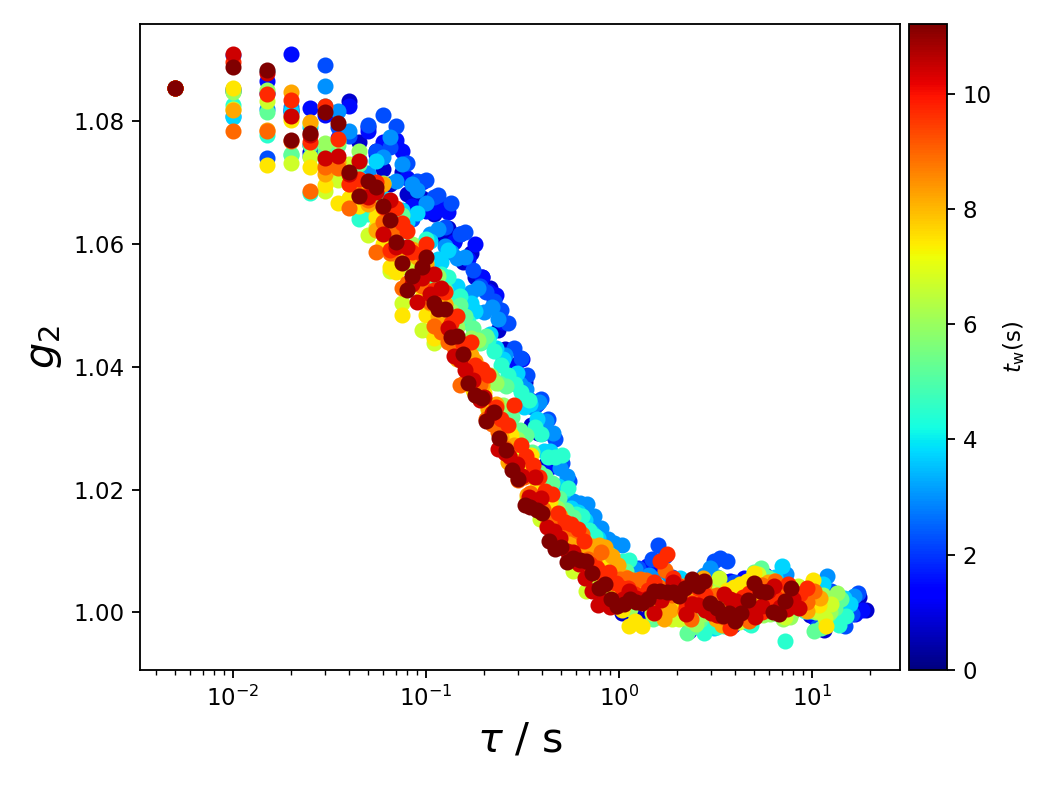

In [14]:
if tt[-1] > 40 and tt[-1] < 350: # typical 200s measurement
    t_cut_hor = np.arange(0,160,6) # times where cuts start
    tau_hor, g2_hor = cut_ttc(ttc, times = t_cut_hor,t_delay=t_exp,nframes=ttc.shape[0], cut='horizontal', t_range=20, t_cutoff=None, reduce=True, nbins=60, plot=True)
elif tt[-1] > 350: # long measurement with high absorber
    t_cut_hor = np.arange(0,200,30)
    tau_hor, g2_hor = cut_ttc(ttc, times = t_cut_hor,t_delay=t_exp,nframes=ttc.shape[0], cut='horizontal', t_range=200, t_cutoff=None, reduce=True, nbins=100, plot=True)
else: # short measurement with low aborber
    t_cut_hor = np.arange(0,12,0.8)
    tau_hor, g2_hor = cut_ttc(ttc, times = t_cut_hor,t_delay=t_exp,nframes=ttc.shape[0], cut='horizontal', t_range=1, t_cutoff=None, reduce=True, nbins=100, plot=True)

max_g2_len_hor = g2_hor[0].shape[0]
for t_c in range(len(g2_hor)):
    if g2_hor[t_c].shape[0]>max_g2_len_hor:
        max_g2_len_hor=g2_hor[t_c].shape[0]
    
# convert g2s from dicts to array, entrys that dont't exist are nans
g2_hor_array = np.full([len(g2_hor.keys()),max_g2_len_hor], np.nan)
tau_hor_array = np.full([len(g2_hor.keys()),max_g2_len_hor], np.nan)
for ik, k in enumerate(g2_hor.keys()):
    g2_hor_array[ik,:g2_hor[k].shape[0]] = g2_hor[k]
    tau_hor_array[ik,:g2_hor[k].shape[0]] = tau_hor[k]
dose_cut_hor = np.round(Dosis(t_cut_hor,absorber),2)   

In [15]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/q_{:.0f}/horizontal_cuts'.format(series,q_ind) not in f:
        grp = f['/scan_{:.0f}/q_{:.0f}'.format(series,q_ind)].create_group('horizontal_cuts')                        

## single exponential fit, offset fixed

<IPython.core.display.Javascript object>


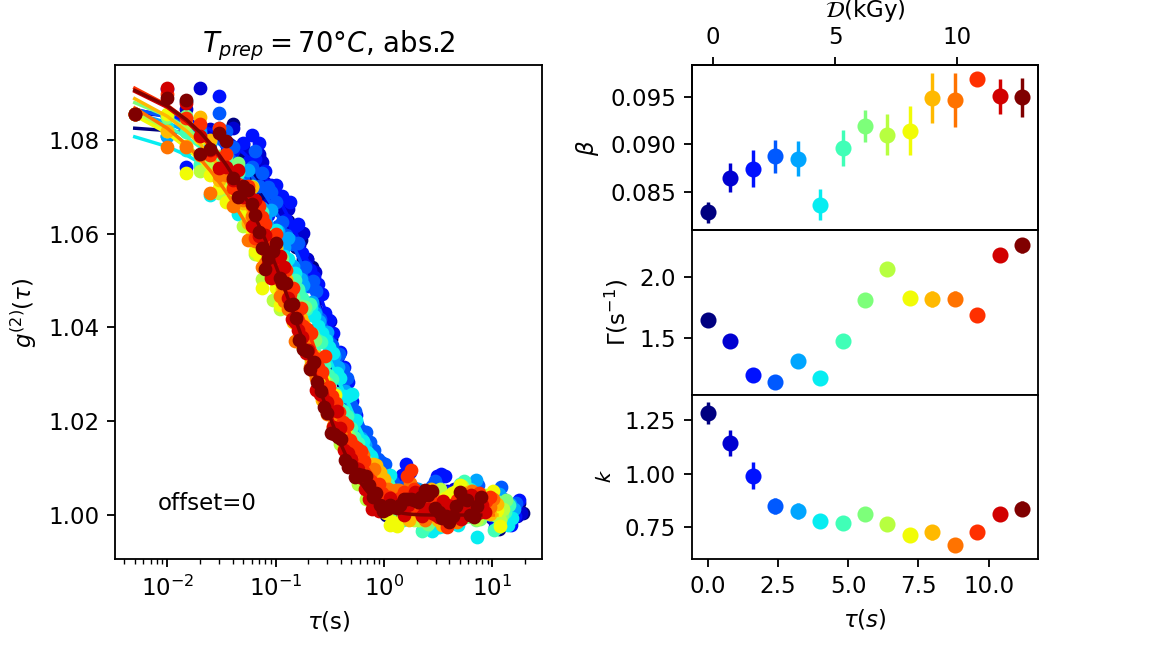

Text(0.5, 1.0, '$T_{prep}=70\\degree C$, abs.2')

In [16]:
from lmfit import Minimizer, Parameters, report_fit

fig  = plt.figure(figsize=(7,4))
ax_g2= plt.axes([0.1,0.15,0.37,0.75],ylabel=r'$g^{(2)}(\tau)$',xlabel=r'$\tau(\mathrm{s})$',xscale='log')
ax_contrast= plt.axes([0.6,0.65,0.3,0.25],ylabel=r'$\beta$')
ax_gamma= plt.axes([0.6,0.4,0.3,0.25],ylabel=r'$\Gamma(\mathrm{s^{-1}})$')
ax_kww= plt.axes([0.6,0.15,0.3,0.25],ylabel=r'$\mathcal{k}$',xlabel=r'$\tau(s)$')
ax_dose = ax_contrast.twiny()
ax_dose.set_xlim(dose_cut_hor.min()-0.07*(dose_cut_hor.max()-dose_cut_hor.min()),dose_cut_hor.max()+0.07*(dose_cut_hor.max()-dose_cut_hor.min()))
ax_dose.xaxis.set_ticks_position('top')
ax_dose.xaxis.set_label_position('top')
ax_dose.set_xlabel(r'$\mathcal{D}(\mathrm{kGy})$')

ax_contrast.set_xticks([])
ax_gamma.set_xticks([])

#define model
def g2_1exp(params, t,data):
    """Model a single exponential decay."""
    contrast = params['contrast']
    gamma = params['gamma']
    kww = params['kww']
    offset = params['offset']
    model = np.add(1 + offset , np.multiply(contrast, np.exp(np.multiply(-2,np.power(np.multiply(gamma, t), kww)))))
    return model-data 

#define parameters
params = Parameters()
params.add('contrast',value=0.097,min=0.03,max=0.097,vary=True)
params.add('gamma',value=0.01,min=0.0001,max=300,vary=True)
params.add('kww',value=1,min=0.5,max=2.5,vary=True)
offset = 0
params.add('offset',value=offset,vary=False)

gammas = np.zeros(len(t_cut_hor))
dgammas = np.zeros(len(t_cut_hor))
kwws = np.zeros(len(t_cut_hor))
dkwws = np.zeros(len(t_cut_hor))
contrasts = np.zeros(len(t_cut_hor))
dcontrasts = np.zeros(len(t_cut_hor))

colors=plt.cm.jet(np.linspace(0,1,len(t_cut_hor)))

for it, t in enumerate(t_cut_hor):
    minner = Minimizer(g2_1exp, params, fcn_args=(tau_hor[it],g2_hor[it]))
    result = minner.minimize(method='differential_evolution')
    
    gammas[it]=result.params['gamma'].value
    dgammas[it]=result.params['gamma'].stderr
    kwws[it]=result.params['kww'].value
    dkwws[it]=result.params['kww'].stderr
    contrasts[it]=result.params['contrast'].value
    dcontrasts[it]=result.params['contrast'].stderr
    
    ax_g2.plot(tau_hor[it],g2_hor[it],color=colors[it],linestyle='',marker='o',markersize=5)
    ax_g2.plot(tau_hor[it],g2_hor[it]+result.residual,color=colors[it])
    
    ax_gamma.errorbar(x=t,y=gammas[it],yerr=dgammas[it],color=colors[it],marker='o')
    ax_kww.errorbar(x=t,y=kwws[it],yerr=dkwws[it],color=colors[it],marker='o')
    ax_contrast.errorbar(x=t,y=contrasts[it],yerr=dcontrasts[it],color=colors[it],marker='o')

ax_g2.text(0.1,0.1,f'offset={offset}',transform = ax_g2.transAxes)

ax_g2.set_title('$T_{prep}=70\degree C$, abs.2')

## single exponential fit with curve_fit

<IPython.core.display.Javascript object>


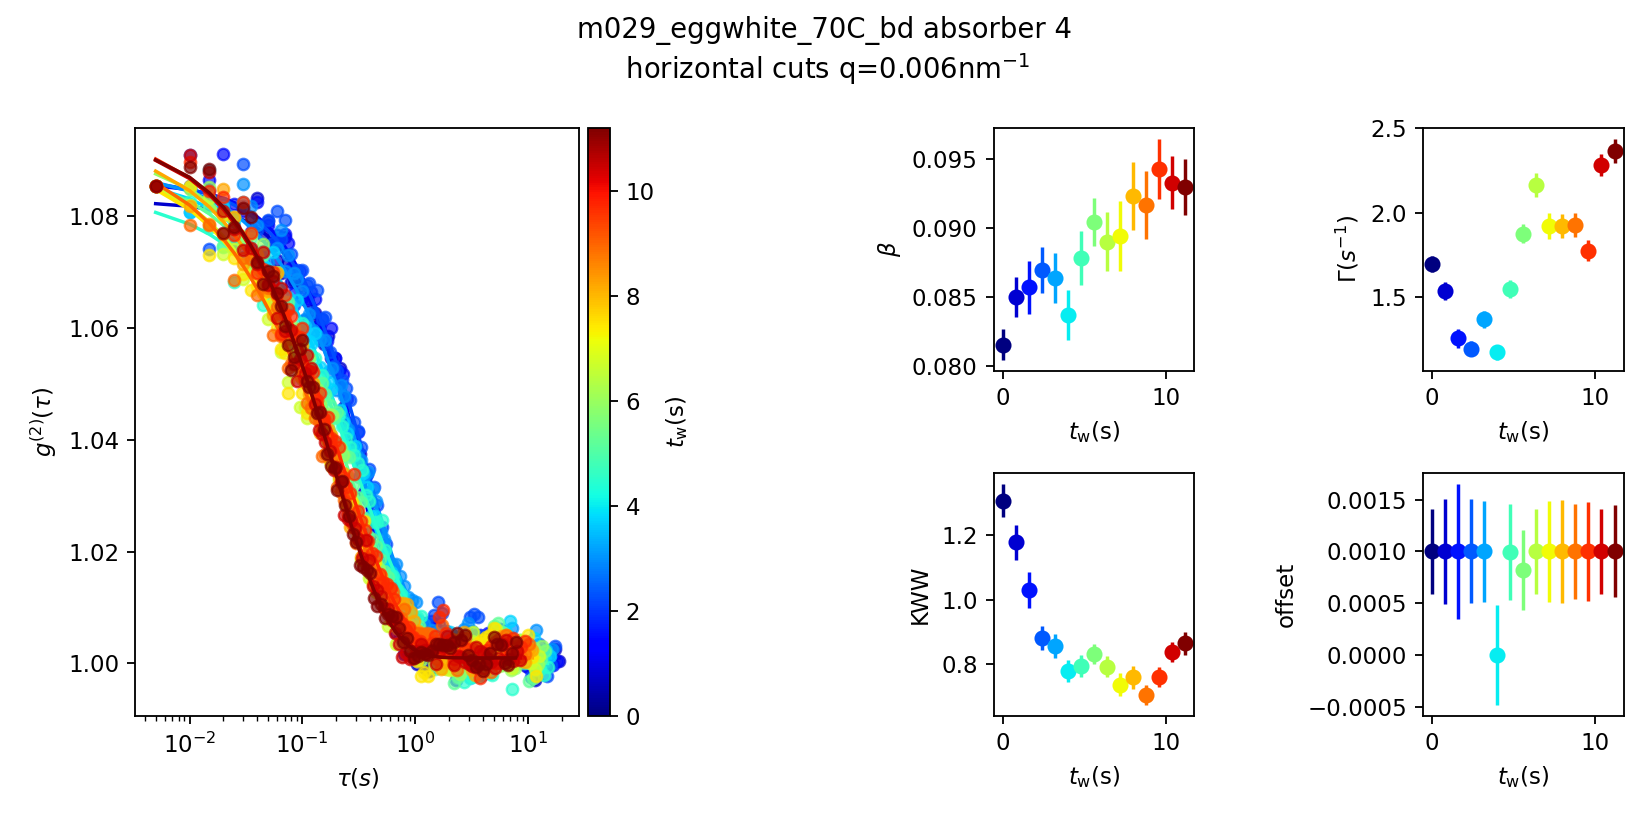

In [17]:
beta_par =  [0.03,0.096,0.097]
gamma_par =  [.00001,0.01,300]
kww_par =  [0.3,1.5,2.5]
offset_par =  [0.0,0.0,0.001]

p0 = [beta_par[1],gamma_par[1],kww_par[1],offset_par[1]]
bound_low = [beta_par[0],gamma_par[0],kww_par[0],offset_par[0]]
bound_high = [beta_par[2],gamma_par[2],kww_par[2],offset_par[2]]

popt, perr, g2_calc, fig_hor =fit_g2(times = t_cut_hor,tau=tau_hor ,
                                     g2=g2_hor, fit_model=1, plot_fit=True,
                                     #max_fit_points=55,
                                     **{'p0':p0,'bounds':(bound_low,bound_high)})

fig_hor.suptitle(str(dataSets['measurement'][measurement_no]) + ' absorber {:.0f}'.format(absorber)+ '\n horizontal cuts q={:.03}'.format(q_values[q_ind]) +'$\mathrm{nm^{-1}}$')
plt.tight_layout()


In [18]:
plt.savefig(f'Figures/{meas_code}/scan{series}_q{q_ind}_g2hor.png',format='png',transparent=True)
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/q_{:.0f}/horizontal_cuts/1_exp_fit'.format(series,q_ind) not in f:
        grp = f['/scan_{:.0f}/q_{:.0f}/horizontal_cuts'.format(series,q_ind)].create_group('1_exp_fit')
    else:
        grp = f['/scan_{:.0f}/q_{:.0f}/horizontal_cuts/1_exp_fit'.format(series,q_ind)]
        
        del grp['g2']
        del grp['tau']
        del grp['t_cut']
        del grp['dose_kGy']
        del grp['fit_parameter_results']
        del grp['fit_parameter_errors']
        
    if '/scan_{:.0f}/q_{:.0f}/horizontal_cuts/1_exp_fit/fit_settings'.format(series,q_ind) in f:
        grp_fit=f['/scan_{:.0f}/q_{:.0f}/horizontal_cuts/1_exp_fit/fit_settings'.format(series,q_ind)]

        del grp_fit['par0']
        del grp_fit['par1']
        del grp_fit['par2']
        del grp_fit['par3']
        #del grp_fit
    else:
        grp_fit = grp.create_group('fit_settings')
            
    grp.create_dataset('g2',data = g2_hor_array)
    grp.create_dataset('tau',data = tau_hor_array)
    grp.create_dataset('t_cut',data = t_cut_hor)
    grp.create_dataset('dose_kGy',data = dose_cut_hor)

    
    grp_fit.create_dataset('par0',data=beta_par)
    grp_fit.create_dataset('par1',data=gamma_par)
    grp_fit.create_dataset('par2',data=kww_par)
    grp_fit.create_dataset('par3',data=offset_par)
    
    data_fit = grp.create_dataset('fit_parameter_results',data = popt)
    grp.create_dataset('fit_parameter_errors',data = perr)
    data_fit.attrs['parameter_names']= ['contrast','Gamma','KWW','offset']

## double exponential fit with curve_fit

<IPython.core.display.Javascript object>


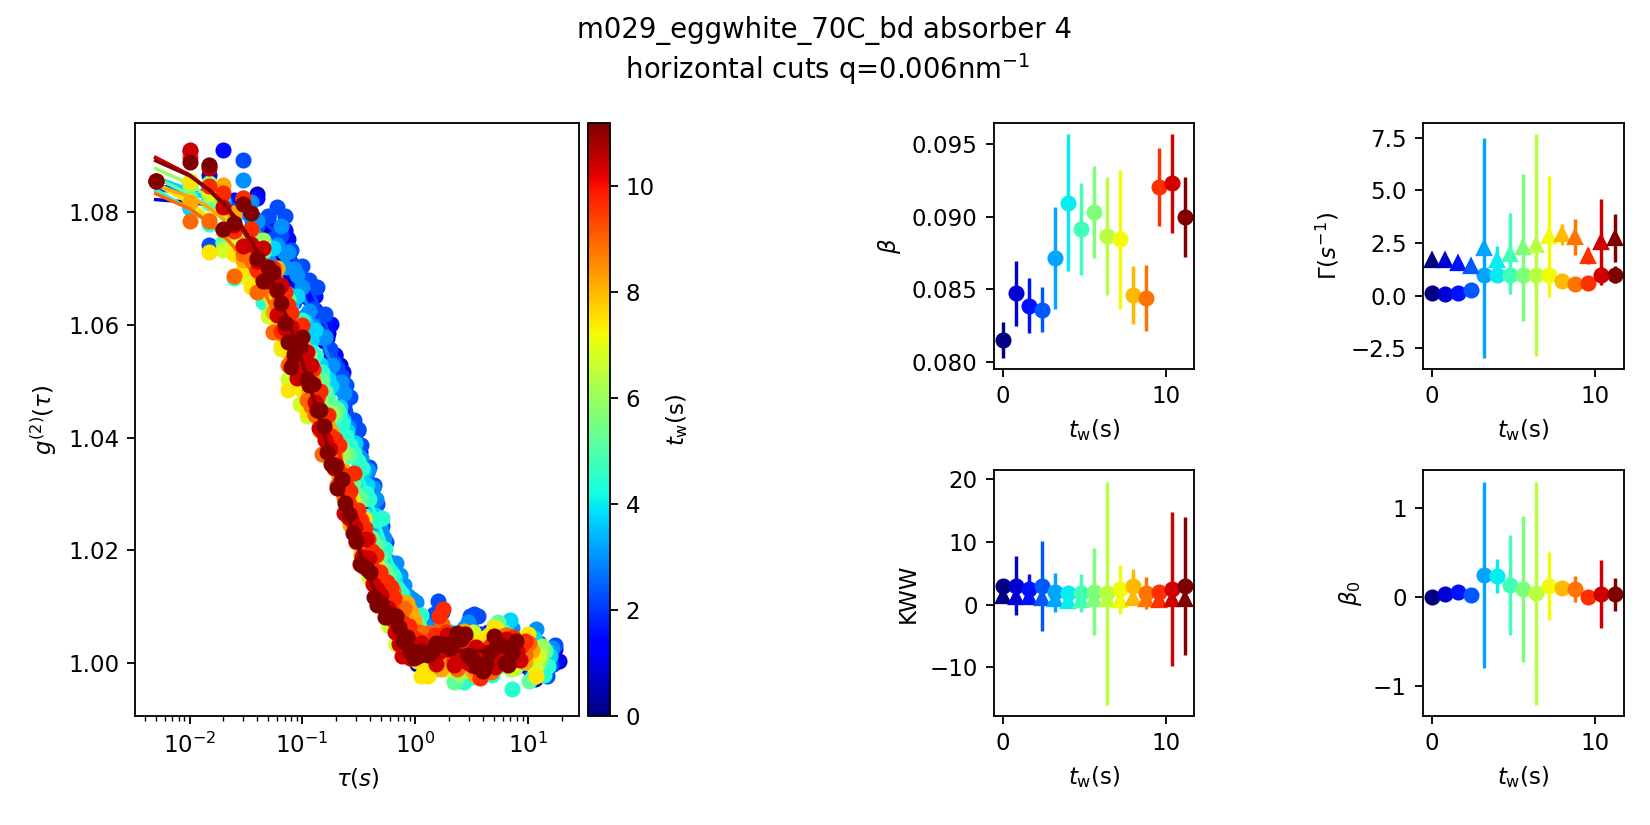

In [19]:
contrast_par = [0.07,0.097,0.097]
beta_1_par = [0,0.25,1]
gamma_1_par = [.01,1,1]
kww_1_par = [1.8,2,3]
gamma_2_par = [0.0001,0.005,100]
kww_2_par = [0.3,1.5,2]
offset_par = [0,0,0.06]

p0 = [contrast_par[1],beta_1_par[1],gamma_1_par[1],kww_1_par[1],gamma_2_par[1],kww_2_par[1],offset_par[1]]
bound_low = [contrast_par[0],beta_1_par[0],gamma_1_par[0],kww_1_par[0],gamma_2_par[0],kww_2_par[0],offset_par[0]]
bound_high = [contrast_par[2],beta_1_par[2],gamma_1_par[2],kww_1_par[2],gamma_2_par[2],kww_2_par[2],offset_par[2]]

popt, perr, g2_calc, fig_2exp =fit_g2(times = t_cut_hor,tau=tau_hor ,
                           g2=g2_hor, fit_model=2, plot_fit=True,
                                     #max_fit_points=66,
                           **{'p0':p0,'bounds':(bound_low,bound_high)})
fig_2exp.suptitle(str(dataSets['measurement'][measurement_no]) + ' absorber {:.0f}'.format(absorber)+ '\n horizontal cuts q={:.03}'.format(q_values[q_ind]) +'$\mathrm{nm^{-1}}$')
plt.tight_layout()

In [20]:
plt.savefig(f'Figures/{meas_code}/scan{series}_q{q_ind}_g2hor_2exp.png',format='png',transparent=True)

with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/q_{:.0f}/horizontal_cuts/2_exp_fit'.format(series,q_ind) not in f:
        grp = f['/scan_{:.0f}/q_{:.0f}/horizontal_cuts'.format(series,q_ind)].create_group('2_exp_fit')
    else:
        grp = f['/scan_{:.0f}/q_{:.0f}/horizontal_cuts/2_exp_fit'.format(series,q_ind)]

        del grp['g2']
        del grp['tau']
        del grp['t_cut']
        del grp['dose_kGy']
        del grp['fit_settings']
        del grp['fit_parameter_results']
        del grp['fit_parameter_error']
        

            
    grp.create_dataset('g2',data = g2_hor_array)
    grp.create_dataset('tau',data = tau_hor_array)
    grp.create_dataset('t_cut',data = t_cut_hor)
    grp.create_dataset('dose_kGy',data = dose_cut_hor)
                       
    grp_fit = grp.create_group('fit_settings')
    grp_fit.create_dataset('par0',data=contrast_par)
    grp_fit.create_dataset('par1',data=beta_1_par)
    grp_fit.create_dataset('par2',data=gamma_1_par)
    grp_fit.create_dataset('par3',data=kww_1_par)                   
    grp_fit.create_dataset('par4',data=gamma_2_par)
    grp_fit.create_dataset('par5',data=kww_2_par)
    grp_fit.create_dataset('par6',data=offset_par)                   
                    

    data_fit = grp.create_dataset('fit_parameter_results',data = popt)
    grp.create_dataset('fit_parameter_error',data = perr)
    data_fit.attrs['parameter_names']= ['contrast','rel_contrast','Gamma1','KWW1','Gamma2','KWW2','offset']

# Part II: $\Gamma$ vs. q at constant Dose

In [21]:
print(sublog)

     meas_id           measurement  temp  ser  ab
101        7  m029_eggwhite_70C_bd    70    1  24
102        7  m029_eggwhite_70C_bd    70    2  18
103        7  m029_eggwhite_70C_bd    70    3  16
104        7  m029_eggwhite_70C_bd    70    4  12
105        7  m029_eggwhite_70C_bd    70    5   8
106        7  m029_eggwhite_70C_bd    70    6   8
107        7  m029_eggwhite_70C_bd    70    7   6
108        7  m029_eggwhite_70C_bd    70    8   6
109        7  m029_eggwhite_70C_bd    70    9   4
110        7  m029_eggwhite_70C_bd    70   10   4
111        7  m029_eggwhite_70C_bd    70   11   2
112        7  m029_eggwhite_70C_bd    70   12   2
113        7  m029_eggwhite_70C_bd    70   13   1
114        7  m029_eggwhite_70C_bd    70   14   1
115        7  m029_eggwhite_70C_bd    70   15   0
116        7  m029_eggwhite_70C_bd    70   16   0


In [23]:
sublog_id = 8
print('measurement: ' + sublog.iloc[sublog_id]['measurement'])
print('series: ' + str(sublog.iloc[sublog_id]['ser']))
print('absorber: ' + str(sublog.iloc[sublog_id]['ab']))

absorber = sublog.iloc[sublog_id]['ab']
series = sublog.iloc[sublog_id]['ser']

measurement: m029_eggwhite_70C_bd
series: 9
absorber: 4


In [24]:
ind_xpcs = d2.db[(d2.db['series']==series) & (d2.db['analysis']=='xpcs')].index.values
t_exp = d2.db['t_exposure'][ind_xpcs[0]]
print(ind_xpcs)
print(t_exp)

tt = d2.get_item(ind_xpcs[0])['twotime_xy']
ttc=d2.get_item(ind_xpcs[0])['twotime_corf'][3][:,:]

[  8 608]
0.005


In [25]:
dose_rate_dict =  {'0':3.95,'1':2.89,'2':2.11,'4':1.135,'6':0.6,'8':0.326,'12':0.094,'16':0.027,'18':0.014,'24':0.0022,'32':0.00018} #kGy/s

target_dose_range = (0.5,1.5) #kGy dose range where to average horizontal cut

#calculate target time range
inverse_dose_rate = 1/dose_rate_dict[str(absorber)] # s/kGy
target_time_range = (inverse_dose_rate*target_dose_range[0],inverse_dose_rate*target_dose_range[1])
time_range_s = np.ceil(target_time_range[1]-target_time_range[0])

if target_time_range[1]>tt[-1]:
    print('Selected dose not in time range')
    print(f'maximum dose reached {len(tt)*t_exp*dose_rate_dict[str(absorber)]}')

mean_dose = int(np.mean([target_dose_range[0],target_dose_range[1]]))
print(mean_dose)
print(target_time_range)

1
(0.44052863436123346, 1.3215859030837005)


In [32]:
q_ind_range = range(1,5) # select q ROIs for fitting

In [33]:
# loop over q ROIs
for ii, q_ind_ in enumerate(q_ind_range):
    ttc=d2.get_item(ind_xpcs[0])['twotime_corf'][q_ind_][:,:]
    tau_cdose, g2_cdose = cut_ttc(ttc, times = [target_time_range[0]],t_delay=t_exp,nframes=ttc.shape[0], cut='horizontal', t_range=time_range_s, t_cutoff=None, reduce=True, nbins=100, plot=False)
    # print(g2_cdose[0].shape)
    if ii == 0:
        g2_cdose_array = np.zeros([len(q_ind_range),len(g2_cdose[0])])
        g2_cdose_array[ii,:]=g2_cdose[0]
    else:
        g2_cdose_array[ii,:]=g2_cdose[0]
tau_cdose_array = tau_cdose[0]

## 1-exp fit

<IPython.core.display.Javascript object>


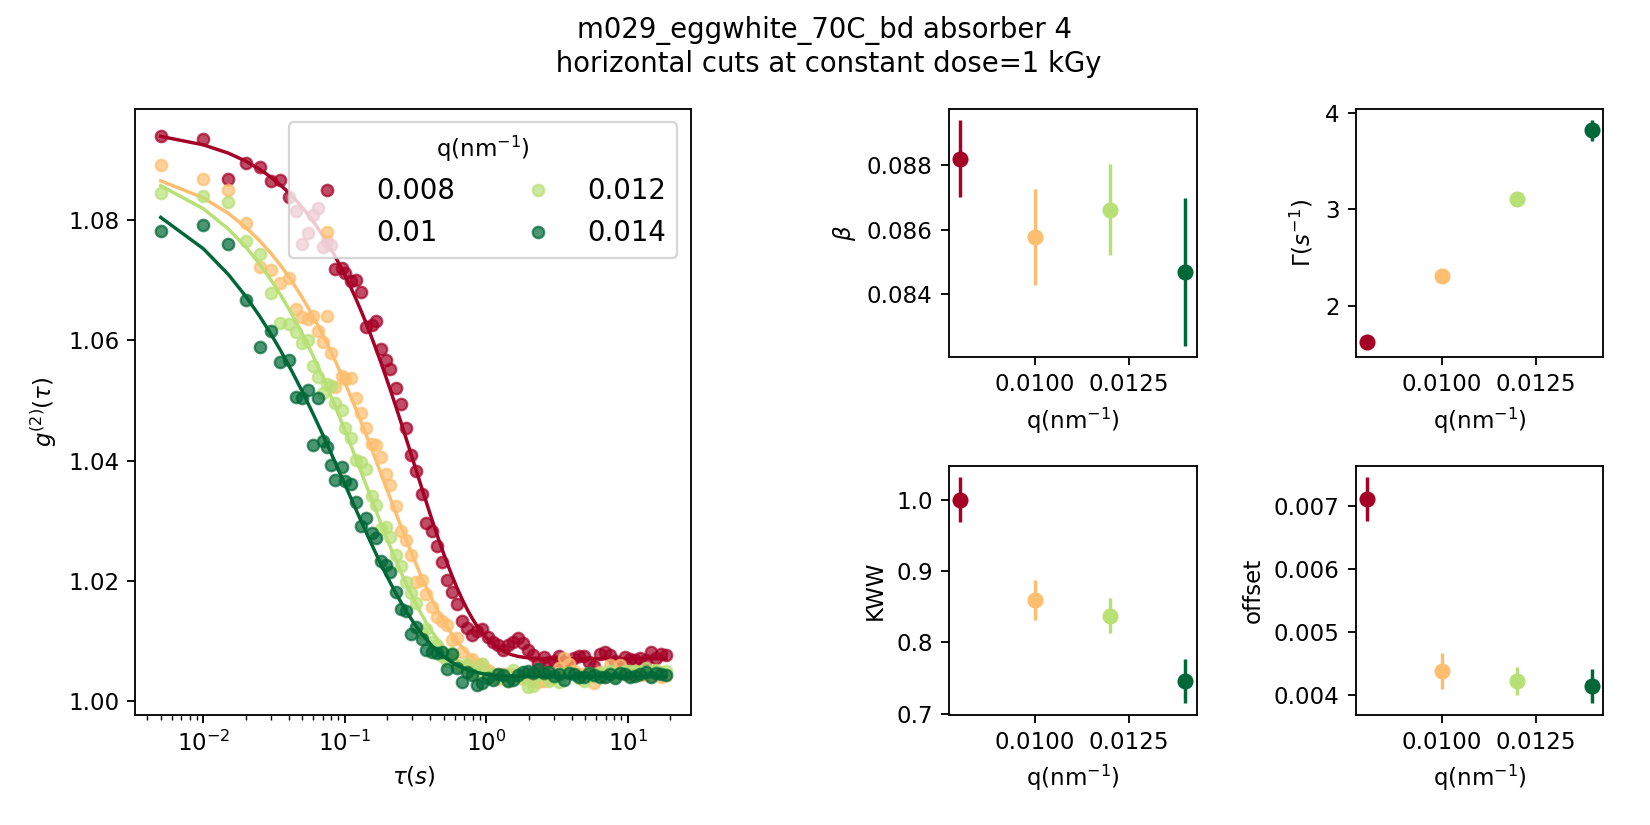

In [34]:
popt, perr, g2_calc, fig_1exp =fit_g2_arrays(q_labels = q_values[q_ind_range],tau=tau_cdose_array ,
                           g2=g2_cdose_array, fit_model=1, plot_fit=True,
                                     #max_fit_points=70,
                           **{'p0':[0.1, .1, 0.5, 0],
                            'bounds':([0.02,.001,0.5,-0.02],
                                      [0.10,20,1,0.07])})
fig_1exp.suptitle(str(dataSets['measurement'][measurement_no]) + ' absorber {:.0f}'.format(absorber)+ '\n horizontal cuts at constant dose={}'.format(mean_dose) +' kGy')
plt.tight_layout()
plt.savefig(f'Figures/{meas_code}/scan{series}_{mean_dose}kGy.png',format='png',transparent=True)


<IPython.core.display.Javascript object>


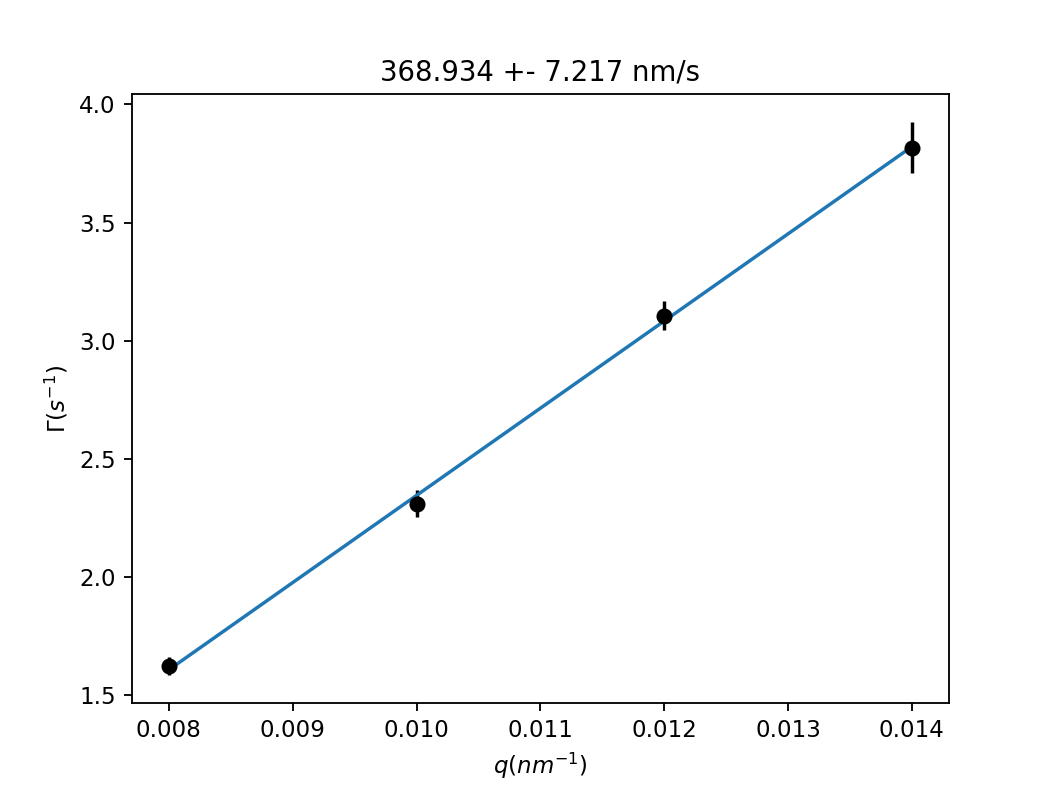

368.934 nm/s 
-1.344 1/s 


In [35]:
fig, ax = plt.subplots()
ax.errorbar(x=q_values[q_ind_range],y=popt[:,1],yerr=perr[:,1],marker='o',linestyle='',color='black')
pars, cov = np.polyfit(x=q_values[q_ind_range],y=popt[:,1],deg=1,cov=True)
ax.plot(q_values[q_ind_range],pars[0]*q_values[q_ind_range]+pars[1])
ax.set_ylabel('$\Gamma(s^{-1})$')
ax.set_xlabel('$q(nm^{-1})$')

print(f'{pars[0]:.3f} nm/s ')
print(f'{pars[1]:.3f} 1/s ')
ax.set_title(f'{pars[0]:.3f} +- {np.sqrt(cov[0,0]):.3f} nm/s')

plt.savefig(f'Figures/{meas_code}/scan{series}_{mean_dose}kGy_fit.png',format='png',transparent=True)

In [36]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/constant_dose'.format(series) not in f:
        grp = f['/scan_{:.0f}'.format(series)].create_group('constant_dose')
        grp2 = grp.create_group('{:.0f}kGy'.format(mean_dose))
    elif '/scan_{:.0f}/constant_dose/{:.0f}kGy'.format(series,mean_dose) not in f:
        grp2 = f['/scan_{:.0f}/constant_dose'.format(series)].create_group('{:.0f}kGy'.format(mean_dose))
    else:
        grp = f['/scan_{:.0f}/constant_dose'.format(series)]
        grp2 = grp['{:.0f}kGy'.format(mean_dose)]

        for name, h5obj in grp2.items():
            del grp2[name]
    
    grp2.create_dataset('g2',data = g2_cdose_array)
    grp2.create_dataset('tau',data = tau_cdose_array)
    grp2.create_dataset('t_range',data = [target_time_range[0],target_time_range[1]])
    grp2.create_dataset('dose_range',data = [target_dose_range[0],target_dose_range[1]])
    grp2.create_dataset('q_nm',data = q_values[q_ind_range])
    grp2.create_dataset('v_nm_s',data = [pars[0]])
    grp2.create_dataset('v_err',data = [np.sqrt(cov[0,0])])
    
    data_fit = grp2.create_dataset('fit_parameter_results',data = popt)
    grp2.create_dataset('fit_parameter_errors',data = perr)
    data_fit.attrs['parameter_names']= ['contrast','Gamma','KWW','offset']

## 2-exp fit

In [ ]:
popt, perr, g2_calc, fig_2exp =fit_g2_arrays(q_labels = q_values[q_ind_range],tau=tau_cdose_array ,
                           g2=g2_cdose_array, fit_model=2, plot_fit=True,
                                     #max_fit_points=50,
                           **{'p0':     [0.11, 0.25,  0.01,    1.5, 1, 1.5, 0.09],
                              'bounds':([0.08,   0,  0.001,   0.3,.01, 0.3, 0.001],
                                        [0.12,  1,     1.5,     3,   100, 3, 0.2])})
fig_2exp.suptitle(str(dataSets['measurement'][measurement_no]) + ' absorber {:.0f}'.format(absorber)+ '\n diagonal cuts at constant dose={}'.format(target_dose_range[0]) +' kGy')
plt.tight_layout()
plt.savefig(f'Figures/{meas_code}/scan{series}_{mean_dose}kGy.png',format='png',transparent=True)


In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(10,3))
#gamma 1
ax[0].errorbar(x=q_values[q_ind_range],y=popt[:,2],yerr=perr[:,2],marker='o',linestyle='',color='black')
pars1, cov1 = np.polyfit(x=q_values[q_ind_range],y=popt[:,2],deg=1,cov=True)
ax[0].plot(q_values[q_ind_range],pars1[0]*q_values[q_ind_range]+pars1[1])

#gamma 2
ax[1].errorbar(x=q_values[q_ind_range],y=popt[:,4],yerr=perr[:,4],marker='o',linestyle='',color='gray')
pars2, cov2 = np.polyfit(x=q_values[q_ind_range[:]],y=popt[:,4],deg=1,cov=True)
ax[1].plot(q_values[q_ind_range],pars2[0]*q_values[q_ind_range]+pars2[1])

for a in [ax[0],ax[1]]:
    a.set_ylabel('$\Gamma(s^{-1})$')
    a.set_xlabel('$q(nm^{-1})$')

ax[0].set_title(f'{pars1[0]:.3f} +- {np.sqrt(cov1[0,0]):.3f} nm/s')
ax[1].set_title(f'{pars2[0]:.3f} +- {np.sqrt(cov2[0,0]):.3f} nm/s')

#print(f'{pars1[0]:.3f} nm/s ')
print(f'{pars1[1]:.3f} +- {np.sqrt(cov1[1,1]):.3f} 1/s  ')
print(f'{pars2[1]:.3f} +- {np.sqrt(cov2[1,1]):.3f} 1/s  ')

plt.savefig(f'Figures/{meas_code}/scan{series}_{mean_dose}kGy_fit.png',format='png',transparent=True)


In [ ]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    if '/scan_{:.0f}/constant_dose'.format(series) not in f:
        grp = f['/scan_{:.0f}'.format(series)].create_group('constant_dose')
        grp2 = grp.create_group('{:.0f}kGy'.format(mean_dose))
    elif '/scan_{:.0f}/constant_dose/{:.0f}kGy'.format(series,mean_dose) not in f:
        grp2 = f['/scan_{:.0f}/constant_dose'.format(series)].create_group('{:.0f}kGy'.format(mean_dose))
    else:
        grp = f['/scan_{:.0f}/constant_dose'.format(series)]
        grp2 = grp['{:.0f}kGy'.format(mean_dose)]

        for name, h5obj in grp2.items():
            del grp2[name]

    
    grp2.create_dataset('g2',data = g2_cdose_array)
    grp2.create_dataset('tau',data = tau_cdose_array)
    grp2.create_dataset('t_range',data = [target_time_range[0],target_time_range[1]])
    grp2.create_dataset('dose_range',data = [target_dose_range[0],target_dose_range[1]])
    grp2.create_dataset('q_nm',data = q_values[q_ind_range])
    grp2.create_dataset('v_nm_s',data = [pars1[0],pars2[0]])
    grp2.create_dataset('v_err',data = [np.sqrt(cov1[0,0]),np.sqrt(cov2[0,0])])
    
    data_fit = grp2.create_dataset('fit_parameter_results_2exp',data = popt)
    grp2.create_dataset('fit_parameter_errors_2exp',data = perr)
    data_fit.attrs['parameter_names']= ['contrast','rel_contrast','Gamma1','KWW1','Gamma2','KWW2','offset']

# Part III: USAXS analysis

In [37]:
sublog_id = 8
print('measurement: ' + sublog.iloc[sublog_id]['measurement'])
print('series: ' + str(sublog.iloc[sublog_id]['ser']))
print('absorber: ' + str(sublog.iloc[sublog_id]['ab']))

absorber = sublog.iloc[sublog_id]['ab']
series = sublog.iloc[sublog_id]['ser']

measurement: m029_eggwhite_70C_bd
series: 9
absorber: 4


In [38]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    f['/scan_{:.0f}'.format(series)].create_group('SAXS')
    f['/scan_{:.0f}/SAXS'.format(series)].create_group('mean_intensity')
    f['/scan_{:.0f}/SAXS'.format(series)].create_group('profiles')
    f['/scan_{:.0f}/SAXS'.format(series)].create_group('scattering_invariant')

In [39]:
ind_saxs =d2.db[(d2.db['series']==series) & (d2.db['analysis']=='saxs')].index.values
ind_xpcs = d2.db[(d2.db['series']==series) & (d2.db['analysis']=='xpcs')].index.values
t_exp = d2.db['t_exposure'][ind_xpcs[0]]
if len(ind_saxs) <1:
    print('No SAXS data found')
else:
    print(ind_saxs)
    print(t_exp)

[248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286]
0.005


### Show averaged SAXS pattern

In [40]:
s=Soq(d2)
ISaxs_mean = np.zeros(np.load(maskfile).shape)
for isaxs in ind_saxs:
    ISaxs_mean+=s.Xana.get_item(isaxs)['Isaxs']

<IPython.core.display.Javascript object>


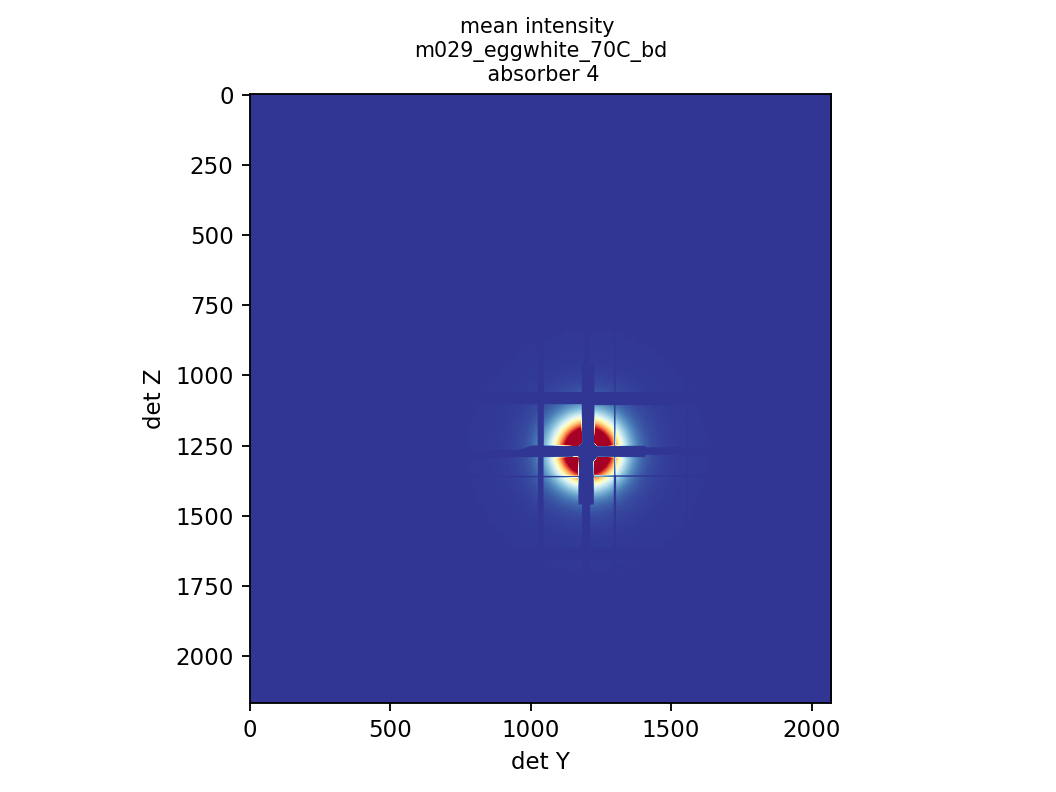

Text(0, 0.5, 'det Z')

In [42]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('RdYlBu_r')
mi, ma = np.nanpercentile(np.multiply(ISaxs_mean,np.load(maskfile)), [10,99.8])
p = ax.imshow(np.multiply(ISaxs_mean,np.load(maskfile)), cmap=cmap,vmin=mi,vmax=ma)
ax.set_title('mean intensity \n' + str(dataSets['measurement'][measurement_no])+f'\n absorber {absorber}',fontsize=9)
ax.set_xlabel('det Y')
ax.set_ylabel('det Z')


In [43]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    grp = f['/scan_{:.0f}/SAXS/mean_intensity'.format(series)]
    grp.create_dataset('detector',data=ISaxs_mean)
  

<IPython.core.display.Javascript object>


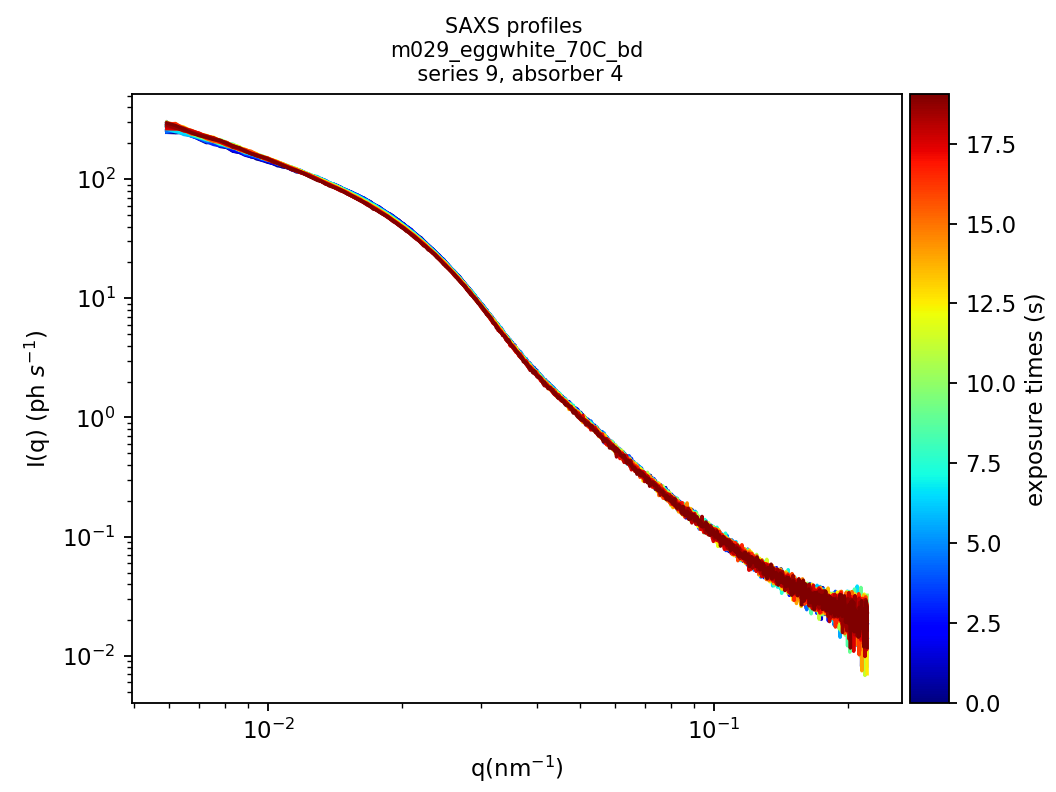

In [45]:
s = Soq(d2) # create object for intensity analysis

qs = s.Xana.get_item(ind_saxs[0])['soq'][:,0] # access q lables for x axis

tw_saxs = np.zeros(len(ind_saxs)) # array for correct waiting times

fig, ax = plt.subplots()
ax.set_prop_cycle(plt.cycler('color',plt.cm.jet(np.linspace(0, 1, len(ind_saxs)))))
cut_end = -200 # omit last X values due to high noise level

ISaxs0 = s.Xana.get_item(ind_saxs[1])['soq'][:,1] # get first SAXS curve, can be used for normalization of for accessing shape
I_saxs_all = np.zeros([len(ind_saxs),len(ISaxs0)]) # array with all SAXS curves, for data storage in data tree

for i, ind in enumerate(ind_saxs): # loop over USAXS entries
    I_saxs_all[i,:] = np.divide(s.Xana.get_item(ind_saxs[i])['soq'][:,1],t_exp) # normalize scattered intensity to exposure time
    tw_saxs[i]=d2.db['first'][ind]*d2.db['t_delay'][ind] # calculate waiting time for USAXS entry
    ax.loglog(qs[:cut_end],I_saxs_all[i,:cut_end]) # plot intensity
ax.set_ylabel('I(q) (ph $s^{-1}$)') 
ax.set_xlabel('q($\mathrm{nm}^{-1}$)') 
ax.set_title('SAXS profiles \n' + str(dataSets['measurement'][measurement_no] + f'\n series {series}, absorber {absorber}'),
             fontsize=9)

add_colorbar(ax,tw_saxs,'exposure times (s)')

#plt.savefig(f'Figures/{meas_code}/scan{series}_SAXSprofiles.png',format='png',transparent=True)


In [46]:
with h5py.File('hdf5Results/' + dataSets['measurement'][measurement_no]+'.hdf5','r+') as f:
    grp = f['/scan_{:.0f}/SAXS/profiles'.format(series)]
    grp.create_dataset('I',data=I_saxs_all)
    grp.create_dataset('q',data=qs)
    grp.create_dataset('t_wait_s',data=tw_saxs)